In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
from algbench import read_as_pandas, Benchmark
import re

font = {'family': 'serif', 'size': 11}
matplotlib.rc('font', **font)

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['figure.figsize'] = [9, 3.5]

In [68]:
optimal_solutions = dict()
for row in Benchmark('results/classical_benchmark/qtg/hard'):
    if row['parameters']['args']['solver'] == 'combo':
        optimal_solutions[row['parameters']['args']['instance']['name']] = row['result']['objective_value']
"""        
qtg_results = read_as_pandas('results/quantum_benchmark/qtg/easy', lambda row: {
    'algorithm': 'qtg',
    'size': row['parameters']['args']['instance']['size'],
    'elapsed_cycles': np.average([measure['cycle_count'] for measure in row['result']['measurements']]) +
                      np.average([measure['cycle_count_decomp'] for measure in row['result']['measurements']]),
    'memory_bits': np.average([measure['qubit_count'] for measure in row['result']['measurements']]),
    'average_gap': np.average([
        (optimal_solutions[row['parameters']['args']['instance']['name']] -
         measure['objective_value']) / optimal_solutions[row['parameters']['args']['instance']['name']]
        for measure in row['result']['measurements']]),
    'best_gap': np.min([
        (optimal_solutions[row['parameters']['args']['instance']['name']] -
         measure['objective_value']) / optimal_solutions[row['parameters']['args']['instance']['name']]
        for measure in row['result']['measurements']]),
    'success_probability': sum([1 for measure in row['result']['measurements'] if measure['objective_value'] == optimal_solutions[row['parameters']['args']['instance']['name']]]) / len(row['result']['measurements']),
    'instance': row['parameters']['args']['instance']['name']
})
"""
combo_results = read_as_pandas('results/classical_benchmark/qtg/hard', lambda row: {
    'size': row['parameters']['args']['instance']['size'],
    'elapsed_cycles': row['result']['elapsed_cycles'] if 'elapsed_cycles' in row['result'] else -1,
    'instance': row['parameters']['args']['instance']['name'],
    'objective_value': row['result']['objective_value'],
    'memory_kb': row['result']['maximum_resident_size_kb']
} if row['parameters']['args']['solver'] == "combo" else None)
ctg_results = read_as_pandas('results/ctg/qtg/hard', lambda row: {
    'algorithm': 'ctg',
    'algorithm_human_readable': 'CTG',
    'elapsed_cycles': np.average(row['result']['elapsed_cycles']),
    'qtg_estimate_cycles': np.average(row['result']['qtg_estimate_cycles']),
    'success_probability': sum([1 for obj in row['result']['objective_values'] if obj == optimal_solutions[row['parameters']['args']['instance']['name']]]) / len(row['result']['objective_values']),
    'size': row['parameters']['args']['instance']['size'],
    'instance': row['parameters']['args']['instance']['name']
})
ctg_results['g'] = ctg_results.apply(
    lambda row: int(re.match(r'.+\_g\_([0-9]+)\_.+', row['instance']).group(1)), axis=1)

combo_results['g'] = combo_results.apply(
    lambda row: int(re.match(r'.+\_g\_([0-9]+)\_.+', row['instance']).group(1)), axis=1)

<Axes: xlabel='size', ylabel='success_probability'>

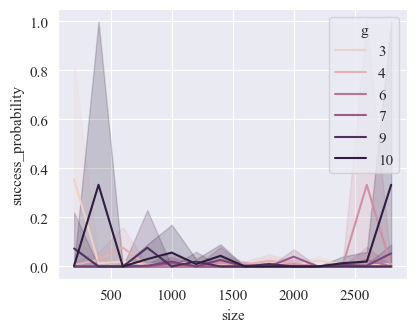

In [42]:
fig, ax = plt.subplots(figsize=(4.5, 3.5))
#sns.lineplot(qtg_results, x='size', y='success_probability', ax=ax, label="QTG")
sns.lineplot(ctg_results, x='size', y='success_probability', ax=ax, hue="g")

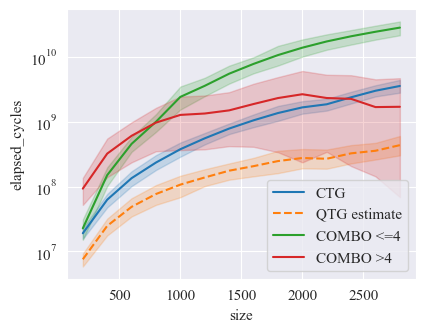

In [66]:
fig, ax = plt.subplots(figsize=(4.5, 3.5))
#sns.lineplot(qtg_results, x='size', y='elapsed_cycles', ax=ax, label="QTG")
sns.lineplot(ctg_results, x='size', y='elapsed_cycles', ax=ax, label="CTG")
sns.lineplot(ctg_results, x='size', y='qtg_estimate_cycles', ax=ax, label="QTG estimate", linestyle='--')
sns.lineplot(combo_results[combo_results["g"] <= 4], x='size', y='elapsed_cycles', ax=ax, label="COMBO <=4")
sns.lineplot(combo_results[combo_results["g"] > 4], x='size', y='elapsed_cycles', ax=ax, label="COMBO >4")
ax.set_yscale('log')

<Axes: xlabel='size', ylabel='memory_kb'>

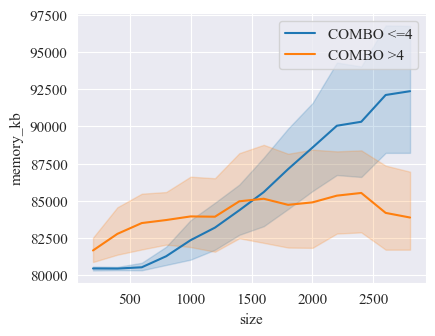

In [69]:
fig, ax = plt.subplots(figsize=(4.5, 3.5))
sns.lineplot(combo_results[combo_results["g"] <= 4], x='size', y='memory_kb', ax=ax, label="COMBO <=4")
sns.lineplot(combo_results[combo_results["g"] > 4], x='size', y='memory_kb', ax=ax, label="COMBO >4")